In [3]:
import pandas as pd

te = pd.read_csv(
    "Danio_rerio_TE_table.tsv",
    sep="\t"
)

# to drop familes with NA age
# te = te[te["age_Myr"].notna() & (te["age_Myr"] != "NA")]

# clean age to float just in case
te["age_Myr"] = pd.to_numeric(te["age_Myr"], errors="coerce")

# split TE_class into broad type and superfamily
# e.g. "DNA/Harbinger" -> type="DNA", family="Harbinger"
te[["type", "family"]] = te["TE_class"].str.split("/", n=1, expand=True)

# per-chr TE family composition (use bp, not just counts)
te["bp"] = te["length"].astype(int)

per_chr_family = (
    te.groupby(["chrom", "family"])
      .agg({"bp": "sum", "TE_name": "count"})
      .rename(columns={"TE_name": "num_instances"})
      .reset_index()
)

per_chr_family.head()

,chrom,family,bp,num_instances
0,NC_007112.7,5s,243397,792
1,NC_007112.7,Academ,7044,49
2,NC_007112.7,CACTA,3167805,19901
3,NC_007112.7,CR1,62333,216
4,NC_007112.7,Copia,379873,1098


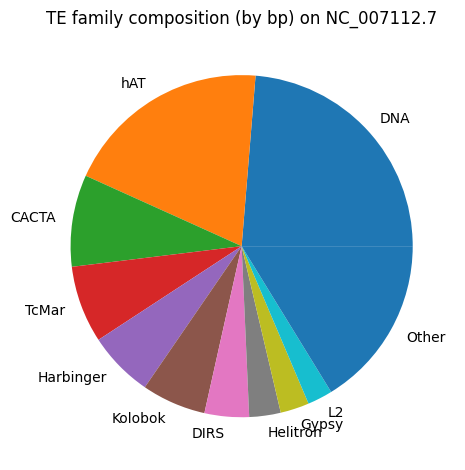

In [8]:
import matplotlib.pyplot as plt

chr_id = "NC_007112.7"
data_chr = per_chr_family[per_chr_family["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("bp", ascending=False).head(N)
others_bp = data_chr["bp"].sum() - top["bp"].sum()

labels = top["family"].tolist()
sizes = top["bp"].tolist()

if others_bp > 0:
    labels.append("Other")
    sizes.append(others_bp)

plt.figure()
plt.pie(sizes, labels=labels)
plt.title(f"TE family composition (by bp) on {chr_id}")
plt.tight_layout()
plt.show()


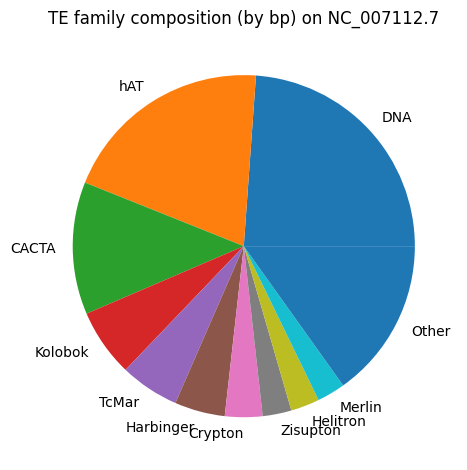

In [9]:
chr_id = "NC_007112.7"
data_chr = per_chr_family[per_chr_family["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("num_instances", ascending=False).head(N)
others_bp = data_chr["num_instances"].sum() - top["num_instances"].sum()

labels = top["family"].tolist()
sizes = top["num_instances"].tolist()

if others_bp > 0:
    labels.append("Other")
    sizes.append(others_bp)

plt.figure()
plt.pie(sizes, labels=labels)
plt.title(f"TE family composition (by bp) on {chr_id}")
plt.tight_layout()
plt.show()


In [12]:
per_chr_type = (
    te.groupby(["chrom", "type"])
      .agg({"bp": "sum", "TE_name": "count"})
      .rename(columns={"TE_name": "num_instances"})
      .reset_index()
)

per_chr_type.head()

,chrom,type,bp,num_instances
0,NC_007112.7,DNA,30395015,141612
1,NC_007112.7,LINE,1899797,6557
2,NC_007112.7,LTR,3841666,9570
3,NC_007112.7,SINE,363620,1280
4,NC_007112.7,Unknown,257579,1333


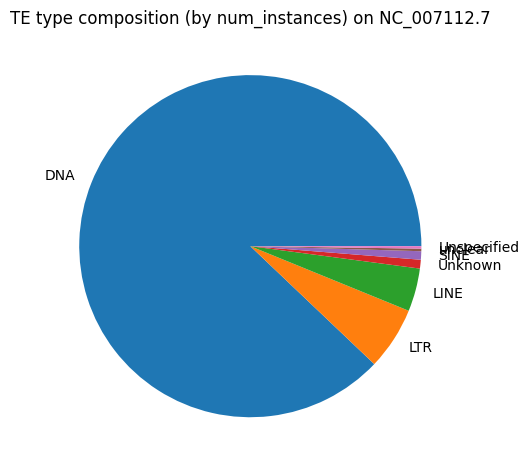

In [14]:
import matplotlib.pyplot as plt

chr_id = "NC_007112.7"
data_chr = per_chr_type[per_chr_type["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("num_instances", ascending=False).head(N)
others_num_instances = data_chr["num_instances"].sum() - top["num_instances"].sum()

labels = top["type"].tolist()
sizes = top["num_instances"].tolist()
if others_num_instances > 0:
    labels.append("Other")
    sizes.append(others_num_instances)

plt.figure()
plt.pie(sizes, labels=labels)
plt.title(f"TE type composition (by num_instances) on {chr_id}")
plt.tight_layout()
plt.show()


In [15]:
avg_length_per_type = (
    te.groupby("type")
      .agg({"bp": ["sum", "count", "mean"]})
      .round(0)
)
avg_length_per_type.columns = ["total_bp", "num_instances", "avg_length"]
avg_length_per_type

,total_bp,num_instances,avg_length
type,,,
DNA,879888540,3973363,221.0
LINE,57560120,191253,301.0
LTR,106361578,264214,403.0
SINE,11724422,42593,275.0
Unknown,8665141,37630,230.0
Unspecified,1980150,11166,177.0
unclear,4842485,15064,321.0


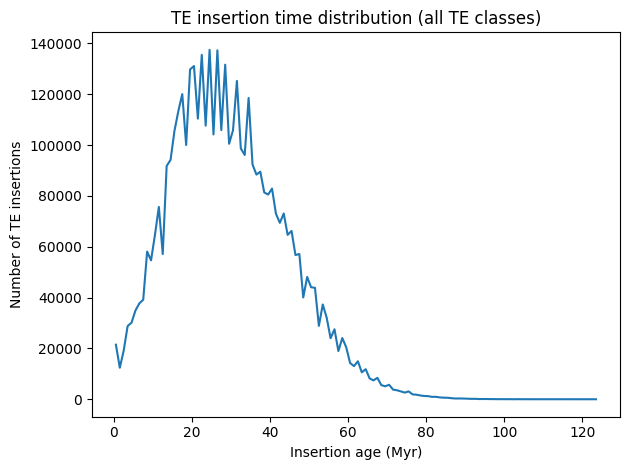

In [16]:
import numpy as np

ages = te["age_Myr"].dropna()

# Choose small bins for high resolution, e.g. 1 Myr
bin_width = 1.0
bins = np.arange(0, ages.max() + bin_width, bin_width)

hist_counts, bin_edges = np.histogram(ages, bins=bins)

# Plot as line (midpoint of each bin vs count)
bin_mid = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure()
plt.plot(bin_mid, hist_counts)
plt.xlabel("Insertion age (Myr)")
plt.ylabel("Number of TE insertions")
plt.title("TE insertion time distribution (all TE classes)")
plt.tight_layout()
plt.show()


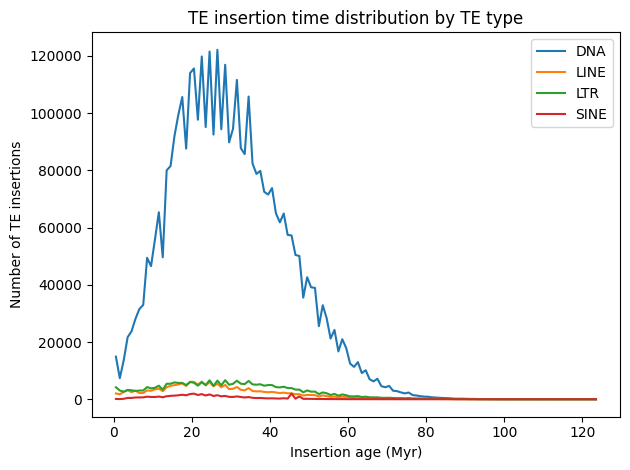

In [17]:
plt.figure()

for t in ["DNA", "LINE", "LTR", "SINE"]:
    sub = te[te["type"] == t]["age_Myr"].dropna()
    if sub.empty:
        continue
    hist_counts, _ = np.histogram(sub, bins=bins)
    plt.plot(bin_mid, hist_counts, label=t)

plt.xlabel("Insertion age (Myr)")
plt.ylabel("Number of TE insertions")
plt.title("TE insertion time distribution by TE type")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import matplotlib.pyplot as plt

def plot_te_family_pie(per_chr_family, chr_id, top_n=8, min_frac=0.02):
    df = per_chr_family[per_chr_family["chrom"] == chr_id].copy()
    total_bp = df["bp"].sum()
    df["frac"] = df["bp"] / total_bp

    # Sort by bp
    df = df.sort_values("bp", ascending=False)

    # Take top_n or families above min_frac, whichever is stricter
    main = df.head(top_n)
    main = main[main["frac"] >= min_frac]
    other_bp = total_bp - main["bp"].sum()

    labels = main["family"].tolist()
    sizes = main["bp"].tolist()

    if other_bp > 0:
        labels.append("Other")
        sizes.append(other_bp)

    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, _ = ax.pie(
        sizes,
        startangle=90
    )
    ax.set_title(f"TE family composition (by bp) on {chr_id}")

    # Put legend outside the pie – no text on slices
    ax.legend(
        wedges, labels,
        title="TE family",
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )

    plt.tight_layout()
    plt.show()


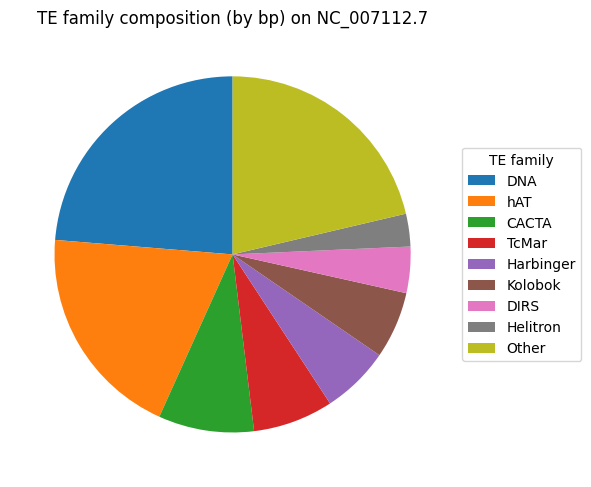

In [19]:
plot_te_family_pie(per_chr_family, "NC_007112.7")


In [20]:
def plot_te_family_bar(per_chr_family, chr_id, top_n=15):
    df = per_chr_family[per_chr_family["chrom"] == chr_id].copy()
    total_bp = df["bp"].sum()
    df["frac"] = df["bp"] / total_bp

    df = df.sort_values("bp", ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.barh(df["family"], df["frac"])
    ax.set_xlabel("Fraction of chromosome covered by family")
    ax.set_ylabel("TE family")
    ax.set_title(f"Top {top_n} TE families on {chr_id}")
    ax.invert_yaxis()  # biggest at top
    plt.tight_layout()
    plt.show()


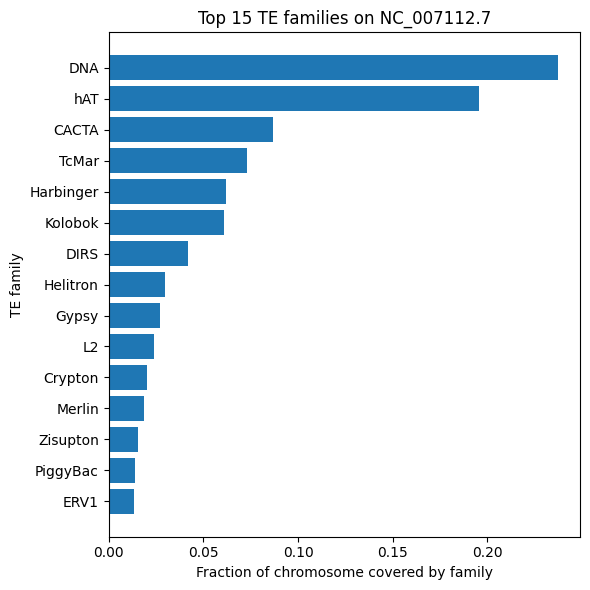

In [21]:
plot_te_family_bar(per_chr_family, "NC_007112.7")
